<a href="https://colab.research.google.com/github/Gousepasha789/Tea-Leaf-disease-detection/blob/main/Tea_Leaf_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Import required libraries

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import numpy as np
import os

print("All required libraries imported successfully!")

All required libraries imported successfully!


In [2]:
# Step 2: Mount Google Drive and load dataset

from google.colab import drive
drive.mount('/content/drive')

# Dataset base path
base_path = "/content/drive/MyDrive/teaLeafBD"

print("Google Drive mounted successfully!")
print(f"Dataset Path set to: {base_path}")

Mounted at /content/drive
Google Drive mounted successfully!
Dataset Path set to: /content/drive/MyDrive/teaLeafBD


In [3]:
# Step 3: Define image parameters

IMAGE_SIZE = (96, 96)
BATCH_SIZE = 16
CHANNELS = 3

print("Image parameters set successfully!")
print(f"Image Size     : {IMAGE_SIZE}")
print(f"Batch Size     : {BATCH_SIZE}")
print(f"Channels       : {CHANNELS} (RGB)")

Image parameters set successfully!
Image Size     : (96, 96)
Batch Size     : 16
Channels       : 3 (RGB)


In [4]:
#Step 4: Create Data Generators & Load Dataset

VAL_SPLIT = 0.20

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    shear_range=0.10,
    zoom_range=0.10,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    validation_split=VAL_SPLIT
)

train_data = train_datagen.flow_from_directory(
    base_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=42
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=VAL_SPLIT)
val_data = val_datagen.flow_from_directory(
    base_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=42
)
print("\nDataset Loaded Successfully!")
print(f"Training samples   : {train_data.samples}")
print(f"Validation samples : {val_data.samples}")
print(f"Number of Classes  : {train_data.num_classes}")
print("Classes:", list(train_data.class_indices.keys()))

Found 4223 images belonging to 7 classes.
Found 1053 images belonging to 7 classes.

Dataset Loaded Successfully!
Training samples   : 4223
Validation samples : 1053
Number of Classes  : 7
Classes: ['1. Tea algal leaf spot', '2. Brown Blight', '3. Gray Blight', '4. Helopeltis', '5. Red spider', '6. Green mirid bug', '7. Healthy leaf']



Class Labels Mapping:
   0 → 1. Tea algal leaf spot
   1 → 2. Brown Blight
   2 → 3. Gray Blight
   3 → 4. Helopeltis
   4 → 5. Red spider
   5 → 6. Green mirid bug
   6 → 7. Healthy leaf

Dataset Analysis:
Total Training Samples   : 4223
Total Validation Samples : 1053
Number of Classes        : 7


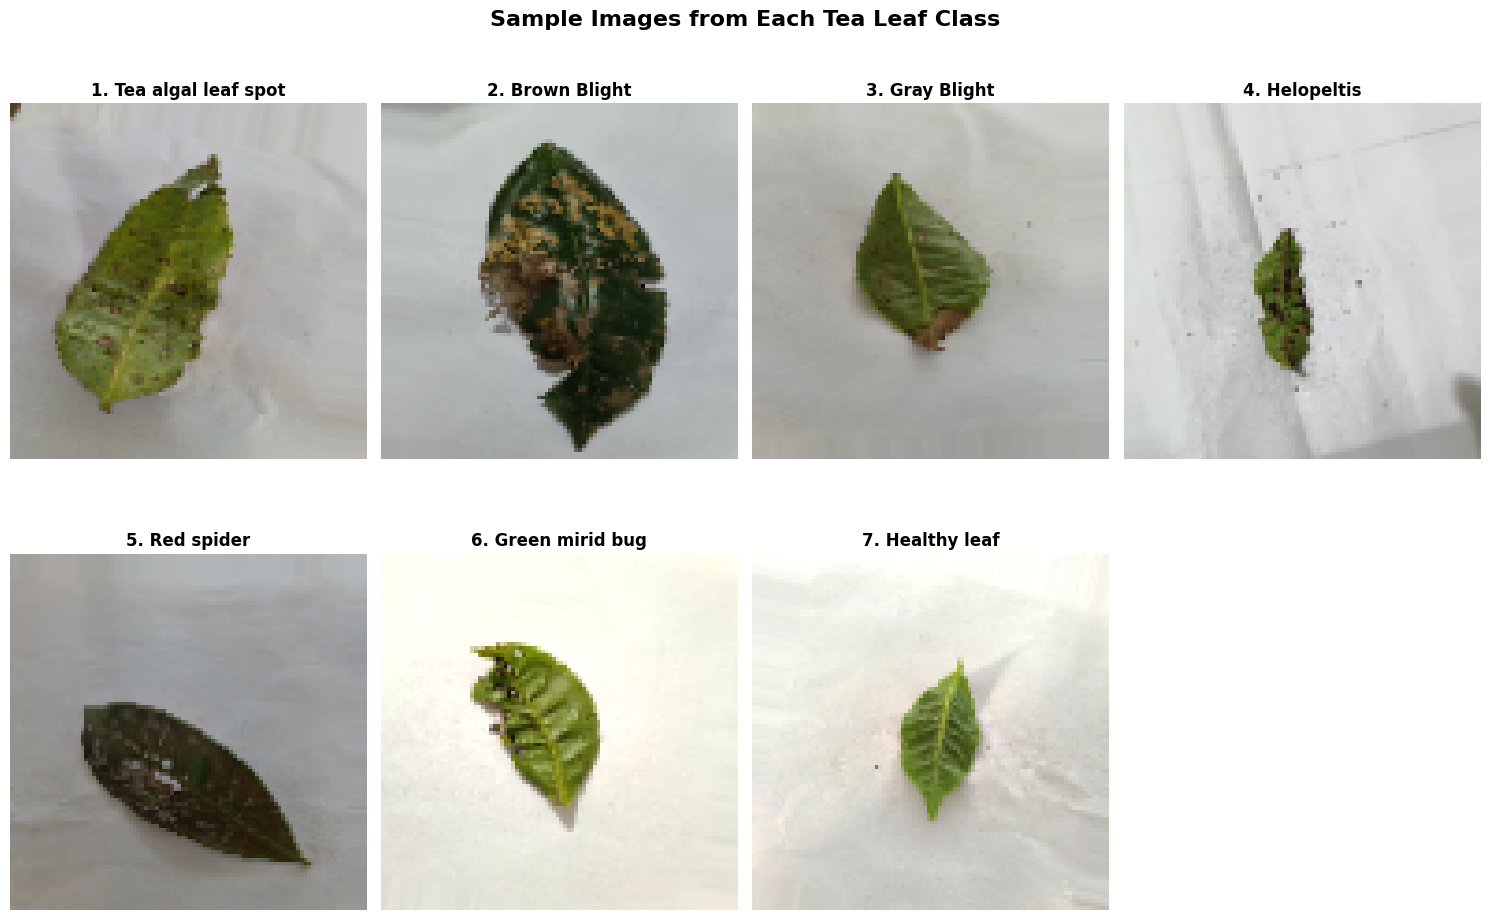

In [5]:
# Step 5: Explore Dataset

print("\nClass Labels Mapping:")
for class_name, idx in train_data.class_indices.items():
    print(f"   {idx} → {class_name}")

print(f"\nDataset Analysis:")
print(f"Total Training Samples   : {train_data.samples}")
print(f"Total Validation Samples : {val_data.samples}")
print(f"Number of Classes        : {train_data.num_classes}")

class_names = list(train_data.class_indices.keys())
plt.figure(figsize=(15, 10))

images, labels = next(train_data)

for i in range(min(len(class_names), 8)):
    plt.subplot(2, 4, i+1)
    class_indices = np.where(np.argmax(labels, axis=1) == i)[0]
    if len(class_indices) > 0:
        idx = class_indices[0]
        plt.imshow(images[idx])
        plt.title(f"{class_names[i]}", fontsize=12, fontweight='bold')
    plt.axis("off")

plt.suptitle("Sample Images from Each Tea Leaf Class", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [85]:
# Step 6: Build CNN Model
num_classes = train_data.num_classes

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], CHANNELS)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()
print(f"\nOptimized CNN model created with {num_classes} output classes")

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)              │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,489,671 (9.50 MB)

 Trainable params: 2,489,671 (9.50 MB)

 Non-trainable params: 0 (0.00 B)


Optimized CNN model created with 7 output classes


In [115]:
# Step 7: Train the CNN Model

checkpoint = ModelCheckpoint("best_tealeaf_model.keras",
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=8,
                           restore_best_weights=True,
                           verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.3,
                              patience=3,
                              min_lr=1e-6,
                              verbose=1)

print("Starting CNN Training...")

EPOCHS = 15

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stop, reduce_lr],
    verbose=1
)

print("\nTraining finished! Best CNN model saved as 'best_tealeaf_model.keras'")

Starting CNN Training...
Epoch 1/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.6755 - loss: 0.8837
Epoch 1: val_accuracy improved from -inf to 0.65432, saving model to best_tealeaf_model.keras
264/264 ━━━━━━━━━━━━━━━━━━━━ 115s 437ms/step - accuracy: 0.6755 - loss: 0.8836 - val_accuracy: 0.6543 - val_loss: 0.9401 - learning_rate: 3.0000e-04
Epoch 2/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.6893 - loss: 0.8710
Epoch 2: val_accuracy improved from 0.65432 to 0.65812, saving model to best_tealeaf_model.keras
264/264 ━━━━━━━━━━━━━━━━━━━━ 113s 427ms/step - accuracy: 0.6894 - loss: 0.8709 - val_accuracy: 0.6581 - val_loss: 0.9638 - learning_rate: 3.0000e-04
Epoch 3/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.7095 - loss: 0.8208
Epoch 3: val_accuracy improved from 0.65812 to 0.72270, saving model to best_tealeaf_model.keras
264/264 ━━━━━━━━━━━━━━━━━━━━ 141s 423ms/step - accuracy: 0.7095 - loss: 0.8207 - val_accuracy: 0.7227 - val_loss: 0.7625 - le

Loading best model for evaluation...
66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 233ms/step - accuracy: 0.7750 - loss: 0.8231
Final Validation Accuracy: 77.30%

Training & Evaluation Complete!
Total Epochs Run : 15


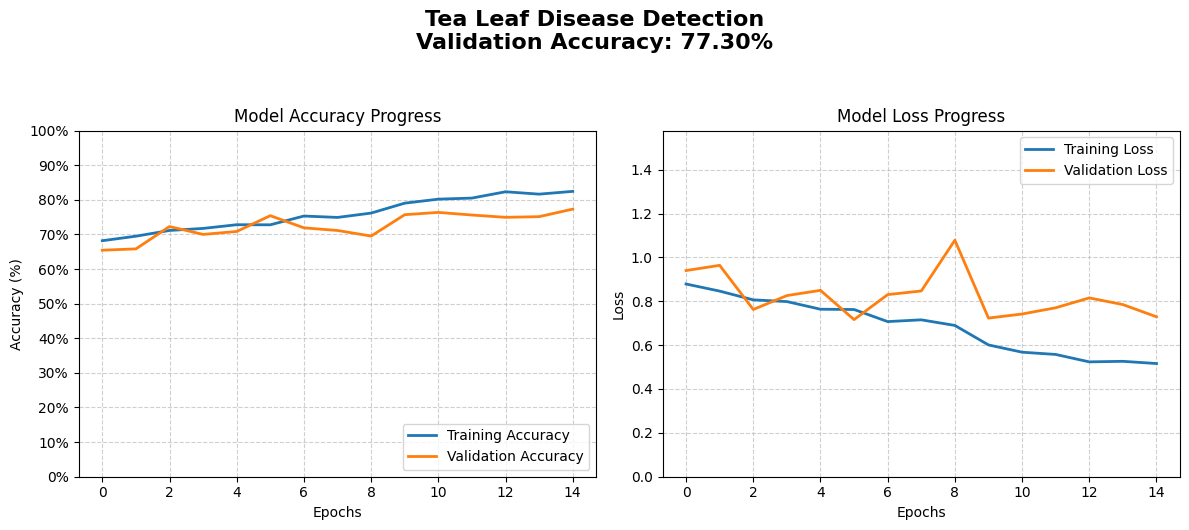

In [116]:
# Step 8: Evaluate Model & Visualize Training

# Final evaluation
print("Loading best model for evaluation...")
best_model = tf.keras.models.load_model("best_tealeaf_model.keras")

loss, acc = model.evaluate(val_data)
print(f"Final Validation Accuracy: {acc*100:.2f}%")

print("\nTraining & Evaluation Complete!")
print(f"Total Epochs Run : {len(history.history['accuracy'])}")

# Plot training history
plt.figure(figsize=(12,5))

plt.suptitle(f"Tea Leaf Disease Detection\nValidation Accuracy: {acc*100:.2f}%",
             fontsize=16, fontweight='bold', y=1.05)

# Accuracy subplot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 1.0)  # 🔹 Force 0–1 scale
plt.yticks(np.linspace(0, 1.0, 11), [f"{int(x*100)}%" for x in np.linspace(0, 1.0, 11)])
plt.legend(loc='lower right')
plt.title('Model Accuracy Progress')
plt.grid(True, linestyle='--', alpha=0.6)
plt.box(True)

# Loss subplot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
max_loss = max(max(history.history['loss']), max(history.history['val_loss']))
plt.ylim(0, max_loss + 0.5)  # auto adjust but starts at 0
plt.legend(loc='upper right')
plt.title('Model Loss Progress')
plt.grid(True, linestyle='--', alpha=0.6)
plt.box(True)

plt.tight_layout()
plt.show()

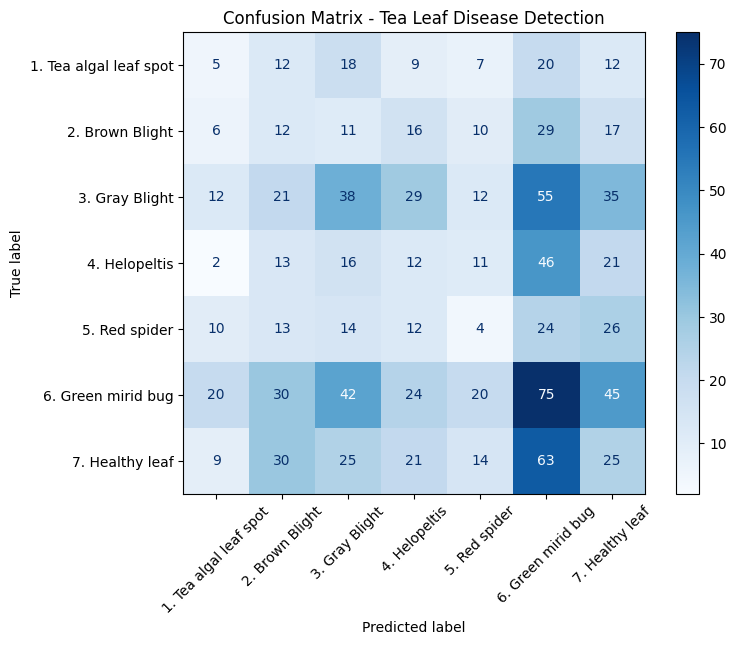

In [117]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get true labels directly from val_data
y_true = val_data.labels

# Predict in one batch
y_pred = np.argmax(best_model.predict(val_data, verbose=0), axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_data.class_indices.keys())

plt.figure(figsize=(8,6))
disp.plot(cmap="Blues", values_format="d", xticks_rotation=45, ax=plt.gca())
plt.title("Confusion Matrix - Tea Leaf Disease Detection")
plt.show()

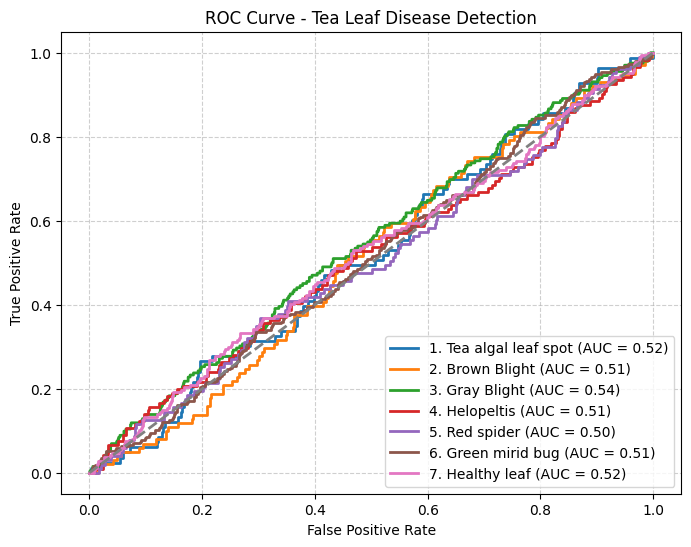

In [119]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# True labels
y_true = val_data.labels

# Predict probabilities
y_pred_prob = best_model.predict(val_data, verbose=0)

# Binarize labels for multi-class ROC
n_classes = len(val_data.class_indices)
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

plt.figure(figsize=(8,6))

# Plot ROC for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{list(val_data.class_indices.keys())[i]} (AUC = {roc_auc:.2f})")

# Random guess line
plt.plot([0,1], [0,1], color="gray", lw=2, linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Tea Leaf Disease Detection")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()